# Contents
- 1. Introduction
- 2. Find interferometer parameters
     - 2.1 Scan ITMs phi to get dark fringe at AS port
     - 2.2 Scan PRM phi to get anti-resonance condition for carrier
     - 2.3 Scan PRC L to get resonance condtion for sidebands
     - 2.4 Scan Schnupp asymmetry to get some side band power at AS port
- 3. Sensing Matrix 


## 1. Introduction
In this notebook, we will find PRMI parameters using Finesse, to achieve an operating point such that carrier is anti-resonant in PRC and sidebands are resonant. To achieve this, we will follow 2.1 to 2.4 to get the operating point. 

Step 1: Scan microscopic lx - ly by moving ITMx and ITMy in opposite direction. Set lx - ly such that AS is dark for the carrier. At this point the Michealson Interferometer acts as a perfectly reflecting compound mirror, forming a cavity between PRM and compound mirror.

Step 2: Scan microscopic lp by moving PRM. Set lp such that carrier is anti-resonant for carrier, by looking at REFL port.

Step 3: Scan macroscopic lp by change length of space between PRM and BS. Set lp such that sidebands are resonant.

Step 4: Scan macroscopic lx - ly and observe the AS18 and AS90 signal to know the sideband power at the AS port. 
     

In [1]:
#%matplotlib notebook
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
#import pykat
import gwinc as gwinc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

pykat.init_pykat_plotting(dpi=96)

#for animations:
from matplotlib import animation, rc
from IPython.display import HTML
plt.style.use('dark_background')
# Update the matplotlib configuration parameters:
plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2,
                     #'font.family': 'serif',
                     #'font.serif': 'noto',
                     'font.size': 11,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:gray',
                     'grid.alpha': 0.3,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((7, 4)),
                     'savefig.dpi': 300,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})


def radar_plot(self, detector_I, detector_Q, DOFs=None, ax=None, title=None, leg=True, autoscale=True):
    """Generates an I-Q quadrature radar plot from this sensing matrix.
    
    Each radar plot shows the magnitude and phase of the response in that
    sensor for each of the DOFs. e.g. Watts in POP_f1 per meter of ETMX motion
                    
    Parameters
    ----------
    detector_I : str
        Detector name in the sensing matrix for I quadrature
        
    detector_Q : str
        Detector name in the sensing matrix for Q quadrature
        
    DOFs : collection[str], optional
        DOFs in the sensing matrix to plot
    
    ax : axis, optional
        Matplotlib axis to put plot into
        
    title: str, optional
        Title of plot
    """
    
    I = self[detector_I]
    Q = self[detector_Q]
    
    A = I + 1j*Q
    
    # FFS, we need to standardize on the colors for the DOFs with an iron fist
    # DARM = DODGER BLUE, CARM = CARNATION, PRCL=PURPLE, MICH = MIDNIGHT, SRCL = Cyan
    clrs = ['xkcd:Dodger Blue', 'xkcd:Red', 'xkcd:Lavender', 'xkcd:Cyan', 'xkcd:Grey']
    
    _ax = ax or plt.subplot(111, projection='polar')
    _ax.set_theta_zero_location('E')
    r_lim = (np.log10(np.abs(A)).min()-1, np.log10(np.abs(A)).max())
    
    if DOFs and any((_ not in A.keys() for _ in DOFs)):
        raise Exception("Sensing matrix is missing one of DOFs ({0}) requested".format(DOFs))
        
    if DOFs:
        keys = tuple(_ for _ in A.keys() if _ in DOFs)
    else:
        keys = A.keys()
        
    scaling = np.linspace(7, 4, len(keys))
    
    for _, s, cc in zip(keys, scaling, clrs):
        theta = np.angle(A[_])
        r     = np.log10(np.abs(A[_]))
        _ax.plot((theta,theta), (r_lim[0], r), lw=s, label=_, alpha=0.6, color=cc)
    ttl = _ax.set_title(title, fontsize=11)
    ttl.set_position([.5, 1.12])
    
    if autoscale == True:
        _ax.set_ylim(r_lim[0], r_lim[1])
    else:
        _ax.set_ylim(6, 11)
    
    if leg==True:
        _ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    _ax.set_rticks(np.arange(*np.round(r_lim)))
    _ax.set_yticklabels(tuple( "$10^{%s}$" % _ for _ in np.arange(*np.round(r_lim), dtype=int)))
    _ax.grid(True, zorder = -10, lw = 2)
    if ax is None:
        plt.tight_layout()
        plt.show()
        
def prettySensingMatrix(self, cmap = 'jet'):
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    # Set colormap equal to seaborns light green color palette
    cmap = plt.get_cmap(cmap)

    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '24'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'xkcd:White'),
      ('background-color', 'xkcd:Black')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '24')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
        
    self = (self.style
      .background_gradient(cmap=cmap, subset=list(self))
      .set_caption('Interferometer Sensing Matrix')
      .format("{:0.3g}")
      .set_table_styles(styles))
    
    return self

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## 2. Find Interferometer Parameters
    lp : Distance between PRM and BS

    lx : Distance between BS and ITMx

    ly : Distance between BS and ITMy

    Degree of freedoms
        PRCL : lp + (lx + ly)/2
        MICH : lx - ly
Finesse code for the interferometer is the following cell

In [2]:
basekat=finesse.kat() # initialising Finesse
basecode = """
#EOM Modulator frequencies 
const mod_freq45 45M
const mod_freq9  9M

#Mirror Parameters
const PRM_R 0.97            #PRM Reflectivity (R)
const PRM_T 0.03            #PRM Transmission (T)
const PRM_L 8.5e-6          #PRM Loss (L)

const ITMx_R 0.98           #ITMx Reflectivity (R)
const ITMx_T 0.01           #ITMx Transmission (T)
const ITMx_L 3.75e-5        #ITMx Loss (L)

const ITMy_R 0.98           #ITMy Reflectivity (R)
const ITMy_T 0.01           #ITMy Transmission (T)
const ITMy_L 3.75e-5        #ITMy Loss (L)

#Lengths
const L_p   50.0            #Space between PRM and BS
const lx    10.0            #Space between BS and ITMx 
const ly    10.0            #Space between BS and ITMy

#Laser
l LASER 1 0 nLASER          # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 nLASER nEOM45_1      # Space (Length = 1 m)

#EOMs 
mod EOM45 $mod_freq45 0.25 1 pm nEOM45_1 nEOM45_2 #EOM 45MHz       
s sEOM45 1 nEOM45_2 nEOM9_1                       #Space between EOMs
mod EOM9 $mod_freq9 0.25 1 pm nEOM9_1 nEOM9_2     #EOM 9MHz
s sEOM9  1 nEOM9_2  nPRM_1                        #Space between EOM and PRM

#Power Recycling Michealson Interferometer
m1 PRM $PRM_T $PRM_L 0 nPRM_1 nPRM_2            #Power Recycling Mirror
s sPRM_BS 50 nPRM_2 nBS_1                       #Space between PRM and BS
bs BS 0.5 0.5 0 45 nBS_1 nBS_2 nBS_3 nBS_4      #Beam Splitter (BS)      
s sBS_ITMy 10 nBS_2 nITMy_1                     #Space between BS ann ITMy
m1 ITMy $ITMy_T $ITMy_L 0 nITMy_1 dump          #Mirror ITMy
s sBS_ITMx 10 nBS_3 nITMx_1                     #Space between BS and ITMx 
m1 ITMx $ITMx_T $ITMx_L 0 nITMx_1 dump          #Mirror ITMx
"""
basekat.parse(basecode,
              keepComments = True,
              preserveConstants = True)


Pykat parsing does not preserve inline comments. Moving inline
comments before command



### 2.1 Scan ITMs to get dark fringe at AS port
Scan phi of ITMx and ITMy in opposite direction, such that lx + ly remains the same. Find lx - ly, when AS_DC is minimum.  

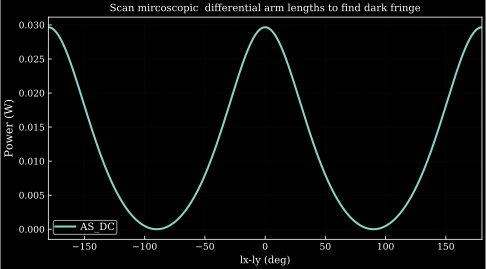

[[-90.0, 3.03817755703524e-17], [90.0, 3.03817755570691e-17]]


In [3]:
#Find the microscopic mirror positions for dark fringe at the AS_DC port.
#Scan microscopic differential ITMx and ITMy, observe the AS_DC port
simulation_code = '''
pd AS_DC nBS_4

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 2000

noplot scITMx
func scITMx = (0.5) * (1) * $scanre
put ITMx phi $scITMx

noplot scITMy
func scITMy = (0.5) * (-1) * $scanre
put ITMy phi $scITMy
 
yaxis abs
'''
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(title = 'Scan mircoscopic  differential arm lengths to find dark fringe',
             ylabel = "Power (W)",
             xlabel = "lx-ly (deg)",
             legend = True)
max_peaks, min_peaks = pykat.external.peakdetect.peakdetect(out_obj['AS_DC'], out_obj.x, lookahead=20)
print(min_peaks)

### 2.2 Scan PRM 'phi' to get anti-resonance condition for carrier
From the above set the lx and ly positions, to get dark fringe at the AS port. At this point all light is reflected back from the beam splitter. This can be treated as a compound mirror. Scan PRM phi, and observe the REFL port DC power see the resonance peaks. The anti-resonance condition is halfway between the resonance peaks.

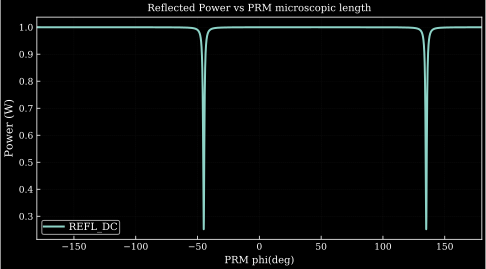

PRM phi for carrier at non resonance conditiion = 45.0


In [4]:
#Find the microscopic position of  PRM such that the carrier is non resonant
#From the above plot AS_DC is dark for lx - ly = 90. To keep inteferometer at
#the dark port, and lx + ly remains the same. Sol: set lx = 45 and ly = -45.
#To Find the microscopic position of the PRM such that carrier is non resonant.
#scan the PRM microscopic length and observe the REFL_DC signal. The PRM and the 
#compound mirror formed by the BS, ITMx and ITMy, acts like cavity.
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0    #set lx and ly such that AS port is dark for carrier
kat_obj.ITMy.phi = -45.0
kat_obj.EOM45.midx = 0.0   #Turn off the EOM so that no sideband peaks appear
kat_obj.EOM9.midx = 0.0    #Trun off the EOM so that no sideband peaks appear
simulation_code = '''
pd REFL_DC nPRM_1          

var scan 0.0
set scanre scan re
xaxis scan re lin -180 180 10000

noplot scPRM
func scPRM = (1) * (1) * $scanre
put PRM phi $scPRM
 
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'PRM phi(deg)',
             ylabel = 'Power (W)',
             title = "Reflected Power vs PRM microscopic length")

max_peaks, min_peaks = pykat.external.peakdetect.peakdetect(out_obj['REFL_DC'], out_obj.x) 
PRM_phi_non_res = (min_peaks[1][0] - min_peaks[0][0])/2.0 #Non resonance condition is in the mid
                                                          #of two resonant peaks
print("PRM phi for carrier at non resonance conditiion = " + str(min_peaks[0][0] + PRM_phi_non_res))

### 2.3 Scan PRC length (lp) to get resonance condtion for sidebands
Set PRM phi to 45.0, at this point carrier is non resonant. Now scan the PRC length by scaning the space between the PRM and BS. Observe the reflected power REFL18 (beat due to 9MHz sidebands), REFL90 (beat due to 45 MHz sidebands)

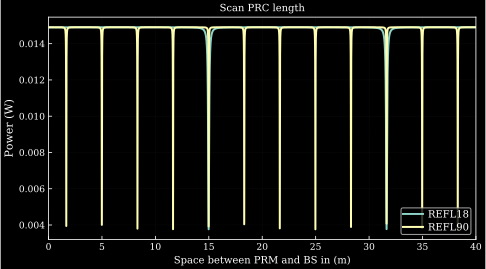

lp for both 9MHz and 45 MHz sidebands to resonant = 14.984


In [5]:
#Find lp length between PRM and BS such that PRC is resonant for the
#both 9MHz and 45 MHz sidebands. 
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0    #Set lx and ly such that AS port is dark
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45.0     #Set PRM phi such that carrier is non resonant

simulation_code = '''
pd1 REFL18 18M nPRM_1
pd1 REFL90 90M nPRM_1

var scan 0.0
set scanre scan re
xaxis scan re lin 0 40 10000

noplot scsPRM_BS
func scsPRM_BS = (1) * (1) * $scanre
put sPRM_BS L $scsPRM_BS
yaxis abs

'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Space between PRM and BS in (m)',
             ylabel = 'Power (W)',
             title = "Scan PRC length")
max_peaks, min_peaks = pykat.external.peakdetect.peakdetect(out_obj['REFL18'], out_obj.x) 
print("lp for both 9MHz and 45 MHz sidebands to resonant = " + str(min_peaks[0][0]))

### 2.4 Scan Schnupp asymmetry 
Scan Schnupp asymmetry by varying (lx - ly) and keeping (lx + ly) constant. Observe the sideband power at AS18, and AS90. Choose asymmetry such that sideband power does not exceed the linear range of actual photodiode used.

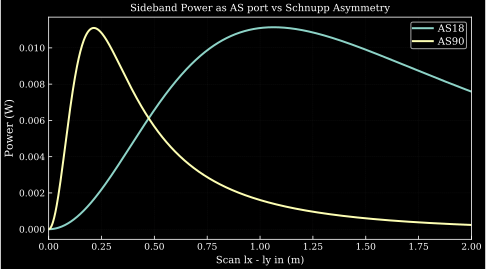

In [23]:
#Find schnupp asymmetery such that we required sideband power at the AS port
kat_obj = basekat.deepcopy()
kat_obj.verbose = False
kat_obj.ITMx.phi = 45.0
kat_obj.ITMy.phi = -45.0
kat_obj.PRM.phi = 45
kat_obj.sPRM_BS.L = 14.984

simulation_code = '''
pd1 AS18 18M nBS_4
pd1 AS90 90M nBS_4

var scan 0.0
set scanre scan re
xaxis scan re lin 0 2 1000

noplot scsBS_ITMx
func scsBS_ITMx = (0.5) * (1) * $scanre
put* sBS_ITMx L $scsBS_ITMx

noplot scsBS_ITMy
func scsBS_ITMy = (0.5) * (-1) * $scanre
put* sBS_ITMy L $scsBS_ITMy
 
yaxis abs
'''
kat_obj.verbose = False
kat_obj.parse(simulation_code)
out_obj = kat_obj.run()
out_obj.plot(xlabel = 'Scan lx - ly in (m)',
             ylabel = 'Power (W)',
             title = "Sideband Power as AS port vs Schnupp Asymmetry")

## 3. Sensing Matrix

In [97]:
basekat = pykat.finesse.kat()
basekat.parse(basecode,
              keepComments = False,
              preserveConstants = True)
kat_obj = basekat.deepcopy()
kat_obj.verbose = False

kat_obj.ITMx.phi = 45.0    #Set ITMx, ITMy phi to get
kat_obj.ITMy.phi = -45.0   #dark port at the AS port
kat_obj.PRM.phi = 45       #Set PRM phi to set PRCL for 
                           #anti-resonant carrier
kat_obj.sPRM_BS.L = 14.984 #Set PRCL for resonant sidebands
schnupp_asymmetry = 0.2    #Set Schnupp asymmetry to sidebands at AS port
kat_obj.sBS_ITMx.L += schnupp_asymmetry/2.0
kat_obj.sBS_ITMy.L -= schnupp_asymmetry/2.0

#create IFO object
kat_obj.IFO = pykat.ifo.IFO(kat_obj,   #kat object
                            ['phase'], #list of tuning keys
                            ['PRM', 'ITMx', 'ITMy']) #list of tuning components

kat_obj.IFO.mod_freq9 = float(kat_obj.EOM9.f)
kat_obj.IFO.mod_freq45 = float(kat_obj.EOM45.f)

#Create Output Objects (Ports)
kat_obj.IFO.AS9 = pykat.ifo.Output(IFO= kat_obj.IFO,           
                                   name= 'AS9',
                                   nodeNames='nBS_4',
                                   f_property_name= 'mod_freq9',
                                   phase= 0)
kat_obj.IFO.AS45 = pykat.ifo.Output(IFO= kat_obj.IFO,
                                   name= 'AS45',
                                   nodeNames='nBS_4',
                                   f_property_name= 'mod_freq45',
                                   phase= 0)
kat_obj.IFO.REFL9 = pykat.ifo.Output(IFO= kat_obj.IFO,
                                   name= 'REFL9',
                                   nodeNames='nPRM_1',
                                   f_property_name= 'mod_freq9',
                                   phase= 0)
kat_obj.IFO.REFL45 = pykat.ifo.Output(IFO= kat_obj.IFO,
                                   name= 'REFL45',
                                   nodeNames='nPRM_1',
                                   f_property_name= 'mod_freq45',
                                   phase= 0)
kat_obj.IFO.POP9 = pykat.ifo.Output(IFO= kat_obj.IFO,
                                   name= 'POP9',
                                   nodeNames='nBS_1',
                                   f_property_name= 'mod_freq9',
                                   phase= 0)
kat_obj.IFO.POP45 = pykat.ifo.Output(IFO= kat_obj.IFO,
                                   name= 'POP45',
                                   nodeNames='nBS_1',
                                   f_property_name= 'mod_freq45',
                                   phase= 0)
#Create Degree of Freedom Objects 
kat_obj.IFO.MICH = pykat.ifo.DOF(IFO= kat_obj.IFO,
                                 _DOFName= 'MICH',
                                 _port= kat_obj.IFO.AS9,
                                 _quad= 'Q',
                                 _optics= ['ITMx', 'ITMy'],
                                 _factors= [0.5, -0.5],
                                 _scale= 1,     # This is not implemented
                                 sigtype= 'z')
kat_obj.IFO.PRCL = pykat.ifo.DOF(IFO= kat_obj.IFO,
                                 _DOFName= 'PRCL',
                                 _port= kat_obj.IFO.REFL9,
                                 _quad= 'I',
                                 _optics= ['ITMx', 'ITMy'],
                                 _factors= [0.5, 0.5],
                                 _scale= 1,
                                 sigtype= 'z')
kat_obj.IFO.update()

In [98]:
DOFs = ['PRCL', 'MICH'];
detectors = [kat_obj.IFO.REFL9.add_transfer(quad='I'),
             kat_obj.IFO.REFL9.add_transfer(quad='Q'),
             kat_obj.IFO.REFL45.add_transfer(quad='I'),
             kat_obj.IFO.REFL45.add_transfer(quad='Q'),
             kat_obj.IFO.POP9.add_transfer(quad='I'),
             kat_obj.IFO.POP9.add_transfer(quad='Q'),
             kat_obj.IFO.POP45.add_transfer(quad='I'),
             kat_obj.IFO.POP45.add_transfer(quad='Q'),
             kat_obj.IFO.AS9.add_transfer(quad='I'),
             kat_obj.IFO.AS9.add_transfer(quad='Q'),
             kat_obj.IFO.AS45.add_transfer(quad='I'),
             kat_obj.IFO.AS45.add_transfer(quad='Q')]
sens_matrix = kat_obj.IFO.sensing_matrix(DOFs= DOFs,
                                         detectors= detectors,
                                         frequency= 100)
prettySensingMatrix(sens_matrix)

The following commands will be parsed
['pd2 REFL9_I_TF 9000000.0 0 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL9_Q_TF 9000000.0 90.0 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL45_I_TF 45000000.0 0 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL45_Q_TF 45000000.0 90.0 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP9_I_TF 9000000.0 0 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP9_Q_TF 9000000.0 90.0 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP45_I_TF 45000000.0 0 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP45_Q_TF 45000000.0 90.0 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 AS9_I_TF 9000000.0 0 $fs nBS_4']
Check IFO kat file
The following commands will be parsed
['pd2 AS9_Q_TF 9000000.0 90.0 $fs nBS_4']
Check IFO kat file
T

,REFL9_I_TF,REFL9_Q_TF,REFL45_I_TF,REFL45_Q_TF,POP9_I_TF,POP9_Q_TF,POP45_I_TF,POP45_Q_TF,AS9_I_TF,AS9_Q_TF,AS45_I_TF,AS45_Q_TF
PRCL,9.39e+07,-2.25e+07,-1.25e+07,-2.63e+07,-4.09e+07,2.51e+07,1.29e+07,-6.24e+06,-2.09e-07,-3.59e-07,4.31e-07,1.06e-06
MICH,-8.49e+05,-3.54e+06,-5.02e+06,2.38e+06,9.58e+05,1.56e+06,-1.21e+06,-2.51e+06,-1.92e+04,-3.29e+04,3.94e+04,9.7e+04


In [99]:
# Find correct demod phase from sensing matrix
output_ports = [kat_obj.IFO.AS9,
                kat_obj.IFO.AS45,
                kat_obj.IFO.REFL9,
                kat_obj.IFO.REFL45,
                kat_obj.IFO.POP9,
                kat_obj.IFO.POP45]

def correct_demod_phase(sens_matrix, DOF, detector, quad = 'I'):
    if quad == 'I':
        quad_phase = 0.0;
    elif quad == 'Q':
        quad_phase = -90.0
    y = sens_matrix[detector.name + '_Q_TF'][DOF]
    x = sens_matrix[detector.name + '_I_TF'][DOF]
    phase = np.arctan2(y,x)*180.0/np.pi + quad_phase
    detector.phase = phase 
    return phase

correct_demod_phase(sens_matrix, 'MICH', kat_obj.IFO.AS9, quad = 'Q')
correct_demod_phase(sens_matrix, 'MICH', kat_obj.IFO.AS45, quad = 'Q')
correct_demod_phase(sens_matrix, 'PRCL', kat_obj.IFO.REFL9, quad = 'I')
correct_demod_phase(sens_matrix, 'PRCL', kat_obj.IFO.REFL45, quad = 'I')
correct_demod_phase(sens_matrix, 'PRCL', kat_obj.IFO.POP9, quad = 'I')
correct_demod_phase(sens_matrix, 'PRCL', kat_obj.IFO.POP45, quad = 'I')
DOFs = ['PRCL', 'MICH'];
detectors = [kat_obj.IFO.REFL9.add_transfer(quad='I'),
             kat_obj.IFO.REFL9.add_transfer(quad='Q'),
             kat_obj.IFO.REFL45.add_transfer(quad='I'),
             kat_obj.IFO.REFL45.add_transfer(quad='Q'),
             kat_obj.IFO.POP9.add_transfer(quad='I'),
             kat_obj.IFO.POP9.add_transfer(quad='Q'),
             kat_obj.IFO.POP45.add_transfer(quad='I'),
             kat_obj.IFO.POP45.add_transfer(quad='Q'),
             kat_obj.IFO.AS9.add_transfer(quad='I'),
             kat_obj.IFO.AS9.add_transfer(quad='Q'),
             kat_obj.IFO.AS45.add_transfer(quad='I'),
             kat_obj.IFO.AS45.add_transfer(quad='Q')]
sens_matrix = kat_obj.IFO.sensing_matrix(DOFs= DOFs,
                                         detectors= detectors,
                                         frequency= 100)
prettySensingMatrix(sens_matrix)

The following commands will be parsed
['pd2 REFL9_I_TF 9000000.0 -13.474692381716903 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL9_Q_TF 9000000.0 76.5253076182831 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL45_I_TF 45000000.0 -115.39817641938811 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 REFL45_Q_TF 45000000.0 -25.398176419388108 $fs nPRM_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP9_I_TF 9000000.0 148.45046382470932 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP9_Q_TF 9000000.0 238.45046382470932 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP45_I_TF 45000000.0 -25.772997229540007 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 POP45_Q_TF 45000000.0 64.22700277045999 $fs nBS_1']
Check IFO kat file
The following commands will be parsed
['pd2 AS9_I_TF 9000000.0 -210.215

,REFL9_I_TF,REFL9_Q_TF,REFL45_I_TF,REFL45_Q_TF,POP9_I_TF,POP9_Q_TF,POP45_I_TF,POP45_Q_TF,AS9_I_TF,AS9_Q_TF,AS45_I_TF,AS45_Q_TF
PRCL,9.66e+07,-3.73e-08,2.91e+07,1.77e-08,4.8e+07,3.73e-09,1.43e+07,1.16e-08,3.58e-18,4.16e-07,2.72e-17,1.14e-06
MICH,-5.23,-3.64e+06,-156,-5.55e+06,447,-1.83e+06,3.38e+03,-2.79e+06,4e-11,3.81e+04,3.27e-11,1.05e+05


## Need to Add Scans

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -180 180 2000
func scITMx = (0.5) * (1.0) * $scanre
noplot scITMx
put* ITMx phi $scITMx
func scITMy = (0.5) * (-1.0) * $scanre
noplot scITMy
put* ITMy phi $scITMy

The following commands are parsed
['pd1 AS9_Q 9000000.0 -120.2159250802475 nBS_4']
# Kat Code Starts##############################
% Generated by PyKat 14.07.2020 23:32:45

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1 nB

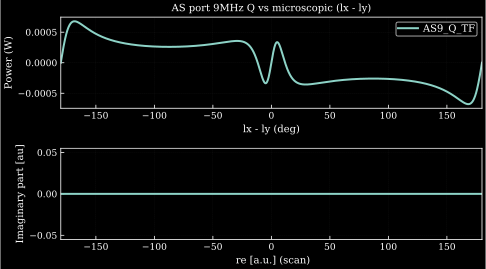

In [111]:
kat_obj.IFO.MICH.kat.parse('yaxis re:im')
out = kat_obj.IFO.MICH.scan(xlimits=[-180,180],
                            steps = 2000,
                            relative = True,
                            extra_cmds = None)
out.plot(detectors = ['AS9_Q_TF'],
         xlabel = 'lx - ly (deg)',
         ylabel = 'Power (W)',
         title  = "AS port 9MHz Q vs microscopic (lx - ly)")

The following commands are parsed.

fsig _MICH ITMx z 1 0.0 0.5
fsig _MICH ITMy z 1 180.0 0.5
xaxis _MICH f log 1000000.0 100000000.0 10000

The following commands are parsed.
['pd2 AS9_Q_TF 9000000.0 -120.2159250802475 $fs nBS_4']
#Code Starts##################################
% Generated by PyKat 14.07.2020 23:33:30

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1 nBS_2 nBS_3 nBS_4
s sBS_ITMy 9.9 nBS_2 nITMy_1
m1 ITMy $ITMy_T $ITMy_L -45.0 nITMy_1 dump
s sBS_ITMx

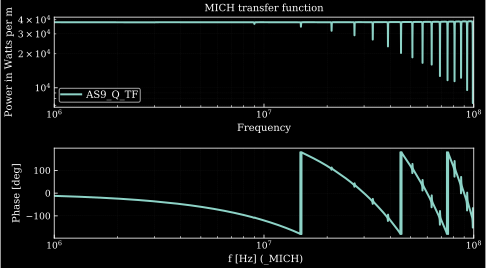

In [112]:
kat_obj.IFO.MICH.kat.parse('yaxis log abs:deg')
out = kat_obj.IFO.MICH.scan_f(linlog = 'log',
                              lower = 1e6,
                              upper = 1e8,
                              steps = 10000)
out.plot(detectors = ['AS9_Q_TF'],
         xlabel = 'Frequency',
         ylabel = 'Power in Watts per m',
         title = 'MICH transfer function')

The following commands are parsed.

fsig _PRCL ITMx z 1 0.0 0.5
fsig _PRCL ITMy z 1 0.0 0.5
xaxis _PRCL f log 1.0 100000.0 10000

The following commands are parsed.
['pd2 REFL9_I_TF 9000000.0 -13.474692381716903 $fs nPRM_1']
#Code Starts##################################
% Generated by PyKat 14.07.2020 23:53:37

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1 nBS_2 nBS_3 nBS_4
s sBS_ITMy 9.9 nBS_2 nITMy_1
m1 ITMy $ITMy_T $ITMy_L -45.0 nITMy_1 dump
s sBS_ITMx 10.1 n

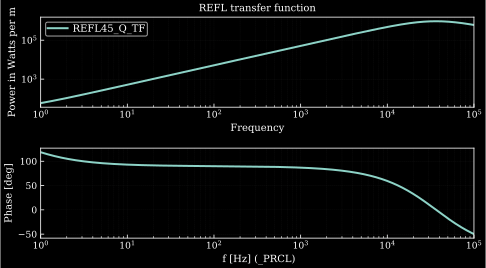

In [140]:
kat_obj.IFO.MICH.kat.parse('yaxis log abs:deg')
out = kat_obj.IFO.PRCL.scan_f(linlog = 'log',
                              lower = 1e0,
                              upper = 1e5,
                              steps = 10000)
out.plot(detectors = ['REFL45_Q_TF'],
         xlabel = 'Frequency',
         ylabel = 'Power in Watts per m',
         title = 'REFL transfer function')

In [101]:
print (kat_obj.IFO.MICH.kat)

% Generated by PyKat 14.07.2020 23:24:55

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1 nBS_2 nBS_3 nBS_4
s sBS_ITMy 9.9 nBS_2 nITMy_1
m1 ITMy $ITMy_T $ITMy_L -45.0 nITMy_1 dump
s sBS_ITMx 10.1 nBS_3 nITMx_1
m1 ITMx $ITMx_T $ITMx_L 45.0 nITMx_1 dump
pd2 REFL9_I_TF 9000000.0 -13.474692381716903 $fs nPRM_1
pd2 REFL9_Q_TF 9000000.0 76.5253076182831 $fs nPRM_1
pd2 REFL45_I_TF 45000000.0 -115.39817641938811 $fs nPRM_1
pd2 REFL45_Q_TF 45000000.0 -25.398176419388108 $fs

In [93]:
print(kat_obj.IFO.kat.yaxis)

abs


The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -180 180 2000
func scITMx = (0.5) * (1.0) * $scanre
noplot scITMx
put* ITMx phi $scITMx
func scITMy = (0.5) * (-1.0) * $scanre
noplot scITMy
put* ITMy phi $scITMy

The following commands are parsed
['pd1 AS9_Q 9000000.0 -120.2159250802475 nBS_4']
# Kat Code Starts##############################
% Generated by PyKat 14.07.2020 23:49:02

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1 nB

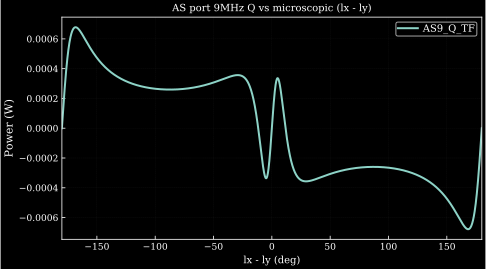

In [137]:
kat_obj.IFO.MICH.kat.parse('yaxis re:im')
out = kat_obj.IFO.MICH.scan(xlimits=[-180,180],
                            steps = 2000,
                            relative = True,
                            extra_cmds = None)
out.plot(detectors = ['AS9_Q_TF'],
         yaxis = 'abs',
         xlabel = 'lx - ly (deg)',
         ylabel = 'Power (W)',
         title  = "AS port 9MHz Q vs microscopic (lx - ly)")

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -180 180 2000
func scITMx = (0.5) * (1.0) * $scanre
noplot scITMx
put* ITMx phi $scITMx
func scITMy = (0.5) * (1.0) * $scanre
noplot scITMy
put* ITMy phi $scITMy

The following commands are parsed
['pd1 REFL9_I 9000000.0 -13.474692381716903 nPRM_1']
# Kat Code Starts##############################
% Generated by PyKat 14.07.2020 23:39:38

const mod_freq45 45000000.0
const mod_freq9 9000000.0
const PRM_R 0.97
const PRM_T 0.03
const PRM_L 8.5e-06
const ITMx_R 0.98
const ITMx_T 0.01
const ITMx_L 3.75e-05
const ITMy_R 0.98
const ITMy_T 0.01
const ITMy_L 3.75e-05
const L_p 50.0
const lx 10.0
const ly 10.0
l LASER 1.0 0.0 0.0 nLASER
s sw 1.0 nLASER nEOM45_1
mod EOM45 $mod_freq45 0.25 1 pm 0.0 nEOM45_1 nEOM45_2
s sEOM45 1.0 nEOM45_2 nEOM9_1
mod EOM9 $mod_freq9 0.25 1 pm 0.0 nEOM9_1 nEOM9_2
s sEOM9 1.0 nEOM9_2 nPRM_1
m1 PRM $PRM_T $PRM_L 45.0 nPRM_1 nPRM_2
s sPRM_BS 14.984 nPRM_2 nBS_1
bs BS 0.5 0.5 0.0 45.0 nBS_1

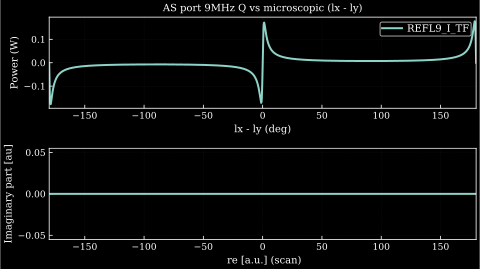

In [123]:
kat_obj.IFO.PRCL.kat.parse('yaxis re:im')
out = kat_obj.IFO.PRCL.scan(xlimits=[-180,180],
                            steps = 2000,
                            relative = True,
                            extra_cmds = None)
out.plot(detectors = ['REFL9_I_TF'],
         xlabel = 'lx - ly (deg)',
         ylabel = 'Power (W)',
         title  = "AS port 9MHz Q vs microscopic (lx - ly)")